Question 1: The Rope Trick

In [1]:
using Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/devel/dynamics-simulation-16-715/HW3_solutions/Q1v1/Project.toml`


In [2]:
using LinearAlgebra
using OrdinaryDiffEq
using ForwardDiff
using Plots

In [3]:
#Parameters
g = 9.81
N = 3 #number of links

#All links are identical
m = 1.0 #link mass
ℓ = 1.0 #link length
J = 1.0 #link inertia
c = 0.01 #joint damping (Nm/rad/sec)

0.01

In [4]:
#Kinematics of an N-link planar pendulum
#Assume all joint angles are defined relative to the previous link

function kinematics(q)
    #Input: q is an N-dimensional vector of joint angles
    #Output: r is 3×N dimensional vector of global x,y,θ coordinates of each link
    
    r = zeros(eltype(q),3,N) #we should give them this to make sure ForwardDiff works
    
    #Assume first link is pinned to the origin
    r[:,1] .= [0.5*ℓ*sin(q[1]); -0.5*ℓ*cos(q[1]); q[1]]
    
    for k = 2:N
        θ = r[3,k-1] + q[k]
        x = r[1,k-1] + 0.5*ℓ*sin(r[3,k-1]) + 0.5*ℓ*sin(θ)
        y = r[2,k-1] - 0.5*ℓ*cos(r[3,k-1]) - 0.5*ℓ*cos(θ)
        
        r[:,k] .= [x;y;θ]
    end
    
    #output is r stacked as a single vector
    return r[:]
end

kinematics (generic function with 1 method)

In [5]:
function potential(q)
    #Input: q is an N-dimensional vector of joint angles 
    #Output: U is potential energy
    
    r = reshape(kinematics(q),3,N)
    y = r[2,:]
    U = sum(m*g*y)
    
    return U
end

potential (generic function with 1 method)

In [6]:
function kinetic(q,q̇)
    #Input: q is an N-dimensional vector of joint angles, q̇ is an N-dimensional vector of joint velocities
    #Output: T is kinetic energy
    
    K = ForwardDiff.jacobian(kinematics,q)
    ṙ = reshape(K*q̇,3,N)
    
    T = 0.5*ṙ[:,1]'*Diagonal([m; m; J])*ṙ[:,1]
    for k = 2:N
        T = T + 0.5*ṙ[:,k]'*Diagonal([m; m; J])*ṙ[:,k]
    end
    
    return T
end

kinetic (generic function with 1 method)

In [7]:
function Lagrangian(q,q̇)
    return kinetic(q,q̇) - potential(q)
end

Lagrangian (generic function with 1 method)

In [8]:
#These can be given
function D1L(q,q̇)
    return ForwardDiff.gradient(dq->Lagrangian(dq,q̇),q)
end

function D2L(q,q̇)
    return ForwardDiff.gradient(dq̇->Lagrangian(q,dq̇),q̇)
end

function D2D2L(q,q̇)
    return ForwardDiff.jacobian(dq̇->D2L(q,dq̇),q̇)
end

function D1D2L(q,q̇)
    return ForwardDiff.jacobian(dq->D2L(dq,q̇),q)
end

D1D2L (generic function with 1 method)

In [9]:
function M(q)
    #Input: q is an N-dimensional vector of joint angles
    #Output: M is an N×N positive-definite mass matrix
    
    return D2D2L(q,zeros(N))
end

M (generic function with 1 method)

In [10]:
function C(q,q̇)
    #Input: q is an N-dimensional vector of joint angles
    #Output: C is an N-dimensional coriolis force vector
    
    D1T = ForwardDiff.gradient(dq->kinetic(dq,q̇),q)
    return D1D2L(q,q̇)*q̇ - D1T
end

C (generic function with 1 method)

In [11]:
function G(q)
    #Input: q is an N-dimensional vector of joint angles
    #Output: G is an N-dimensional gravitational force vector
    
    return ForwardDiff.gradient(dq->potential(dq),q)
end

G (generic function with 1 method)

In [12]:
function manipulator_dynamics(x)
    #Input: x is an 2N-dimensional vector [q; q̇]
    #Output: ẋ is an 2N-dimensional vector [q̇; q̈]
    
    q = x[1:N]
    q̇ = x[N+1:end]
    
    #Hint: don't forget to add joint damping
    q̈ = M(q)\(-C(q,q̇)-G(q)-c*q̇)
    
    ẋ = [q̇; q̈]
end

manipulator_dynamics (generic function with 1 method)

In [13]:
#Initial conditions corresponding to upright equilibrium
q0 = [pi; zeros(N-1)]
q̇0 = zeros(N)
x0 = [q0; q̇0]

6-element Vector{Float64}:
 3.141592653589793
 0.0
 0.0
 0.0
 0.0
 0.0

In [14]:
#Simulate near upward equilibrium using RK4 with 50Hz steps
h = 0.02
Tf = 30.0
T = 0:h:Tf
Nt = length(T)
xhist = zeros(2*N,Nt)
xhist[:,1] .= x0 + 1e-3*randn(2*N) #Add some noise to initial conditions

for k = 1:(Nt-1)
    ẋ1 = manipulator_dynamics(xhist[:,k])
    ẋ2 = manipulator_dynamics(xhist[:,k] + 0.5*h*ẋ1)
    ẋ3 = manipulator_dynamics(xhist[:,k] + 0.5*h*ẋ2)
    ẋ4 = manipulator_dynamics(xhist[:,k] + h*ẋ3)
    
    xhist[:,k+1] .= xhist[:,k] + (h/6.0)*(ẋ1 + 2*ẋ2 + 2*ẋ3 + ẋ4)
end

In [29]:
function endpoint_kinematics(x)
    q = [0;x[1:N]]
    xs = zeros(N+1)
    ys = zeros(N+1)
    for k = 2:N+1
        θ_n = sum(q[1:k])
        xs[k] = xs[k-1] + ℓ*sin(θ_n)
        ys[k] = ys[k-1] - ℓ*cos(θ_n)
    end
    return xs, ys
end

let
    fps = 25
    skip_factor = Int((1/h)/fps)
    anim = @animate for i = 1:skip_factor:length(T)
        IJulia.clear_output(true)
        println(string(Int(round(100*i/length(T))))*"% of animation loaded")
        t = T[i]
        x_rk4 = xhist[:,i]
        xs_rk4, ys_rk4 = endpoint_kinematics(x_rk4)
        plot(xs_rk4,ys_rk4,color = :red, xlim = [-N,N],ylim=[-N,N], aspect_ratio = :equal, label = "RK4",
              lw = 2, xlabel = "x", ylabel = "y")
        
    end
#     gif(anim, "anim.gif", fps = fps) # run the cell again with this commented out to stop the animation
end

100% of animation loaded


Animation("/var/folders/hq/3s_qsf8x1zl35bk1v32wssb80000gn/T/jl_GXQdX2", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000742.png", "000743.png", "000744.png", "000745.png", "000746.png", "000747.png", "000748.png", "000749.png", "000750.png", "000751.png"])

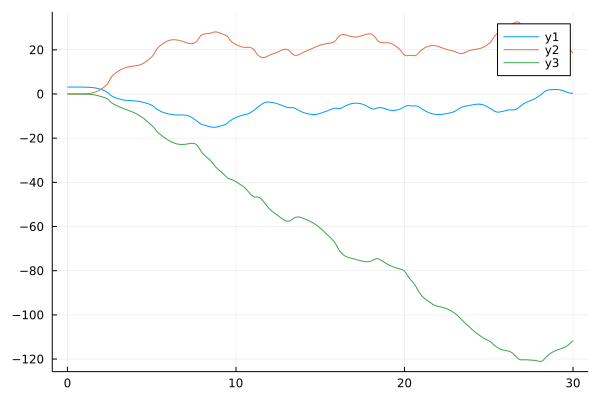

In [23]:
#TODO: Animate with MeshCat
plot(T,xhist[1,:])
plot!(T,xhist[2,:])
plot!(T,xhist[3,:])

In [24]:
#Clearly the system is unstable
#Let's verify this by checking the eigenvalues of the A matrix at the equilibrium

A = ForwardDiff.jacobian(dx->manipulator_dynamics(dx),x0)
eigvals(A) #Should see some positive real eigenvalues

6-element Vector{Float64}:
 -3.9983305688546102
 -2.4859586953584634
 -1.7835540771410199
  1.7816505981010875
  2.473757924765804
  3.9724348184872036

In [25]:
#Now we're going to drive the base of the pendulum up and down with a sinusoidal input
#We could do this by explicitly adding a DOF to the system and a corresponding force input, but we're going to try another way that doesn't involve adding states.
#Assume we have a mechanism that oscillates the base in the vertical direction with an amplitude ϵ and frequency f0

ϵ = 0.25 #base drive amplitude (meters)
f0 = 5.0 #base drive frequency (Hz)

function y_base(t)
    return ϵ*sin(2*pi*f0*t)
end

y_base (generic function with 1 method)

In [25]:
#Now we're going to write a new kinematics function that is time varying to account for the motion of the base

function kinematics(q,t)
    #Input: q is an N-dimensional vector of joint angles, t is time
    #Output: r is 3×N dimensional vector of global x,y,θ coordinates of each link
    
    #There's probably a cleaner way to do this...
    r = zeros(eltype([q;t]),3,N)
    
    #Assume first link is pinned to the oscillating mechanism, which oscillates about the origin in the y direction
    yb = y_base(t)
    r[:,1] .= [0.5*ℓ*sin(q[1]); yb-0.5*ℓ*cos(q[1]); q[1]]
    
    for k = 2:N
        θ = r[3,k-1] + q[k]
        x = r[1,k-1] + 0.5*ℓ*sin(r[3,k-1]) + 0.5*ℓ*sin(θ)
        y = r[2,k-1] - 0.5*ℓ*cos(r[3,k-1]) - 0.5*ℓ*cos(θ)
        
        r[:,k] .= [x;y;θ]
    end
    
    #output is r stacked as a single vector
    return r[:]
end

kinematics (generic function with 2 methods)

In [26]:
#Implement potential energy with this new time-varying kinematics

function potential(q,t)
    #Input: q is an N-dimensional vector of joint angles, t is time
    #Output: U is potential energy
    
    r = reshape(kinematics(q,t),3,N)
    y = r[2,:]
    U = sum(m*g*y)
    
    return U
end

potential (generic function with 2 methods)

In [27]:
#Implement kinetic energy with this new time-varying kinematics

function kinetic(q,q̇,t)
    #Input: q is an N-dimensional vector of joint angles, q̇ is an N-dimensional vector of joint velocities, t is time
    #Output: T is kinetic energy
    
    K = ForwardDiff.jacobian(dq->kinematics(dq,t),q)
    ṙ = reshape(K*q̇ + ForwardDiff.derivative(dt->kinematics(q,dt),t),3,N)
    
    T =  0.5*ṙ[:,1]'*Diagonal([m; m; J])*ṙ[:,1]
    for k = 2:N
        T = T + 0.5*ṙ[:,k]'*Diagonal([m; m; J])*ṙ[:,k]
    end
    
    return T
end

kinetic (generic function with 2 methods)

In [28]:
#New time-varying Lagrangian

function Lagrangian(q,q̇,t)
    return kinetic(q,q̇,t) - potential(q,t)
end

Lagrangian (generic function with 2 methods)

In [29]:
#These can be given
#Overloading Lagrangian derivatives with new time-varying versions

function D1L(q,q̇,t)
    return ForwardDiff.gradient(dq->Lagrangian(dq,q̇,t),q)
end

function D2L(q,q̇,t)
    return ForwardDiff.gradient(dq̇->Lagrangian(q,dq̇,t),q̇)
end

function D2D2L(q,q̇,t)
    return ForwardDiff.jacobian(dq̇->D2L(q,dq̇,t),q̇)
end

function D1D2L(q,q̇,t)
    return ForwardDiff.jacobian(dq->D2L(dq,q̇,t),q)
end

D1D2L (generic function with 2 methods)

In [30]:
function oscillating_dynamics(x,t)
    #Input: x is an 2N-dimensional vector [q; q̇]
    #Output: ẋ is an 2N-dimensional vector [q̇; q̈]
    
    q = x[1:N]
    q̇ = x[N+1:end]
    
    #Hint: The Euler-Lagrange equation still holds when the Lagrangian is time varying,
    #You can either just apply the EL equation, or you can figure out how to modify the manipulator equation
    #to include a new term that accounts for the time-varying base motion
    
    q̈ = D2D2L(q,q̇,t)\(D1L(q,q̇,t) - D1D2L(q,q̇,t)*q̇ - ForwardDiff.derivative(dt->D2L(q,q̇,dt),t) - c*q̇)  
    ẋ = [q̇; q̈]
end

oscillating_dynamics (generic function with 1 method)

In [31]:
function rk4step(xk,t)
    ẋ1 = oscillating_dynamics(xk, t)
    ẋ2 = oscillating_dynamics(xk + 0.5*h*ẋ1, t + 0.5*h)
    ẋ3 = oscillating_dynamics(xk + 0.5*h*ẋ2, t + 0.5*h)
    ẋ4 = oscillating_dynamics(xk + h*ẋ3, t + h)
    
    return xk + (h/6.0)*(ẋ1 + 2*ẋ2 + 2*ẋ3 + ẋ4)
end

rk4step (generic function with 1 method)

In [32]:
#Simulate near upward equilibrium using RK4 with 50Hz steps
h = 0.02
Tf = 30.0
T = Array(0:h:Tf)
Nt = length(T)
xhist = zeros(2*N,Nt)
xhist[:,1] .= x0 + 1e-3*randn(2*N)

for k = 1:(Nt-1)
    xhist[:,k+1] .= rk4step(xhist[:,k], T[k])
end

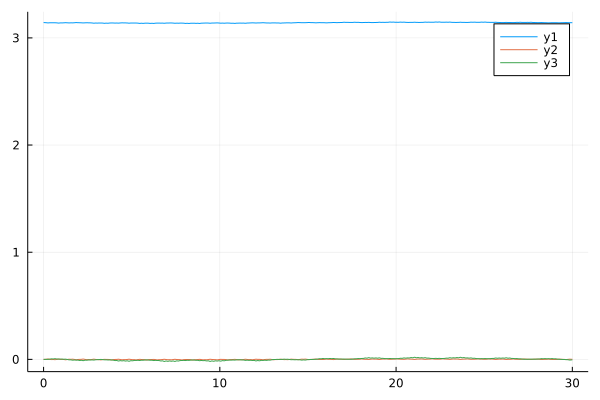

In [33]:
#ToDo: animate
plot(T,xhist[1,:])
plot!(T,xhist[2,:])
plot!(T,xhist[3,:])

In [36]:
#Clearly this system is now stable about the upward equilibrium
#Try playing around with ω0. You should find that there is a critical frequency above which it is stable (and below which it is not)
#Let's try proving stability analytically. To do this we're going to calculate something called the Monodromy matrix,
#which is the discrete-time A matrix evaluated over exactly one period of oscillation of the system parameters

#Since we are driving the base at 5Hz and simulating at 50Hz, we need to compute A over 10 RK4 steps

function one_period_rk4(x0)
    x = deepcopy(x0)
    for k = 1:10
        x .= rk4step(x,h*(k-1))
    end
    return x
end
Amon = ForwardDiff.jacobian(dx->one_period_rk4(dx),x0)

6×6 Matrix{Float64}:
  -0.312027    1.18644   0.0580784   0.191866     0.0177893  -1.65486e-5
   1.16795    -2.21139   0.101081    0.0178011    0.162306    0.00144013
   0.16232     1.75334   0.0913299  -0.00552932   0.0237988   0.198572
 -10.9164     16.3887    0.288645    1.75831     -0.213347   -0.0489658
  16.3084    -37.8351    1.18621    -0.197091     2.05058    -0.0291544
  -2.73923    22.6659   -4.68745    -0.390663    -0.428221    1.728

In [37]:
#Now check eigenvalues of the Monodromy matrix. They should all be inside the unit circle, indicating stability over an oscillation period
abs.(eigvals(Amon))

6-element Vector{Float64}:
 0.9971808354296724
 0.9971808354296724
 0.9987439517978899
 0.9987439517978899
 0.9997997247979477
 0.9997997247979477